In [1]:
import json, requests
import nltk
import re
from nltk.corpus import sentiwordnet as swn
import time
import timeit
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import numpy as np
import urllib.request, urllib.parse, urllib.error
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore

In [2]:
def get_reddit_stats(url, num_its):
    '''
    Parameters:
    url (str): Reddit url where we'll scrape data from 
    example: 'http://www.reddit.com/r/cryptocurrency/top.json?sort=top&t=year'
    
    num_its (int): The number of times specified to run the program using the 'after' endpoint
    
    Returns:
    dfs (DataFrame): DataFrame containing post title's, date/time posted, and the number of upvotes
    
    '''
    # delay program a bit to avoid getting blocked by Reddit
    time.sleep(2)
    
    # create lists to hold the post title (text), time in utc format, and the number of upvotes
    text = []
    times = []
    up = []

    # I decided to use the requests package to scrape the data (which is in JSON format)
    r = requests.get(url,  headers={'user-agent': 'Mozilla/5.0'})

    # the title, time, and upvotes can be found in "children", which can be found in "data"
    for post in r.json()['data']['children']:
        text.append(post['data']['title'])
        times.append(post['data']['created_utc'])
        up.append(post['data']['ups'])
        
    num = 0
    
    # there is an "after" attribute in the url which essentially loops to the next page with more posts
    # I put a try/except to break out of the function once the data is null
    while num < num_its:
        try:
            urla = url + '&after=' + r.json()['data']['after']
            r = requests.get(urla, headers={'user-agent': 'Mozilla/5.0'})
            for post in r.json()['data']['children']:
                text.append(post['data']['title'])
                times.append(post['data']['created_utc'])
                up.append(post['data']['ups'])


            num += 1
        except:
            num = num_its
            break
        

    text = np.array(text)
    times = np.array(times)
    up = np.array(up)
    
    dfs = pd.DataFrame({'Sentence' : text, 'Time' : times, 'Up Votes' : up})

    return dfs

In [3]:
txt = get_reddit_stats('http://www.reddit.com/r/cryptocurrency/top.json?sort=top&t=year',10000)


In [4]:
subreddits = ['bitcoin', 'btc', 'ethereum', 'ethtrader', 'Crypto_Currency_News','cryptomarkets']
for sub in subreddits:
    url = 'http://www.reddit.com/r/{}/top.json?sort=top&t=year'.format(sub)
    txt = txt.append(get_reddit_stats(url,10000))
    print(sub)


bitcoin
btc
ethereum
ethtrader
Crypto_Currency_News
cryptomarkets


In [5]:
#Drop posts with the same post titles
txt.drop_duplicates(subset = 'Sentence',keep = 'first', inplace = True)
txt.isnull().sum()

Sentence    0
Time        0
Up Votes    0
dtype: int64

In [6]:
txt.head()

,Sentence,Time,Up Votes
0,The true power of Bitcoin 🔥,1.560846e+09,14633
1,"Ladies and gentlemen, $10,000 = 1 Bitcoin once...",1.561160e+09,9311
2,Sarah nailed it.,1.560526e+09,6778
3,Trump: “I am not a fan of Bitcoin and other Cr...,1.562892e+09,6283
4,I mean...,1.587849e+09,4978


In [7]:
# Initialize NLTK's sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()
# create lists to append our sentiment scores too
sen = []
neg = []
neu = []
pos = []
com = []
# Iterate through all the post titles in our DataFrame
for sentence in txt['Sentence']:
    sen.append(sentence)
    neg.append(list(sid.polarity_scores(sentence).values())[0])
    neu.append(list(sid.polarity_scores(sentence).values())[1])
    pos.append(list(sid.polarity_scores(sentence).values())[2])
    com.append(list(sid.polarity_scores(sentence).values())[3])
# convert all the lists to NumPy array's
sen = np.array(sen)
neg = np.array(neg)
neu = np.array(neu)
pos = np.array(pos)
com = np.array(com)
# create a DataFrame with all of our Sentiment Scores
df = pd.DataFrame({'Sentence' : sen, 'Negative' : neg, 'Neutral' : neu, 'Positive' : pos, 'Compound' : com})
df = df.set_index('Sentence')
# Merge our original DataFrame (txt) with our DataFrame containing the sentiment of the post title's
txt = txt.set_index('Sentence')
txt = txt.join(df)

In [14]:
txt = txt.reset_index()
txt['Date'] = pd.to_datetime(txt['Time'] , unit = 's').dt.date
txt = txt.sort_values('Date')
txt = pd.read_csv("txt.csv")
t = txt.Sentence
t

0       "Lightning On the Horizon" would be my title f...
1                           At a Coinstar in Lubbock, TX.
2       Bitcoin and Ethereum Trading Coming to E*Trade...
3       DigiByte - New Cooperation With HoneyPod! - Ma...
4                      Why is the UI/UX of DApps so poor?
                              ...                        
7220    Bitcoin Is Confirming Its Safe Haven Status in...
7221    EIP 1559 (gas burning) Implementation Call Nex...
7222    Data shows Ethereum 2.0 is sparking accumulati...
7223                Winklevoss with the mental gymnastics
7224    I was banned from r/bitcoin for saying people ...
Name: Sentence, Length: 7225, dtype: object

In [11]:
!pip install transformers
from transformers import pipeline

# Allocate a pipeline for sentiment-analysis
nlp = pipeline('sentiment-analysis')

Couldn't reach server at 'https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-uncased-finetuned-sst-2-english-modelcard.json' to download model card file.
Creating an empty model card.


In [15]:
import time
sentiments = []

start = time.time()
for i in range(len(t)):
    sentiments.append(nlp(t[i]))
    if i % 100 == 0:
        print(i, time.time() - start)
        start = time.time()

0 0.2243976593017578
100 16.868365049362183
200 16.841246366500854
300 17.318986654281616
400 16.874234199523926
500 16.22836709022522
600 16.44063091278076
700 17.05535626411438
800 17.653075456619263
900 18.04288387298584
1000 17.659828424453735
1100 16.258735179901123
1200 16.47989559173584
1300 16.614097833633423
1400 17.502007484436035
1500 17.988873958587646
1600 18.26207685470581
1700 17.291454792022705
1800 17.650437355041504
1900 17.276193857192993
2000 17.699472904205322
2100 17.779354095458984
2200 17.149048805236816
2300 17.69723868370056
2400 17.233156204223633
2500 17.515825510025024
2600 16.437042474746704
2700 18.491454362869263
2800 17.636695623397827
2900 17.021523237228394
3000 17.070250749588013
3100 18.364176273345947
3200 18.605236768722534
3300 18.668898105621338
3400 18.287216186523438
3500 18.010741472244263
3600 18.21931219100952
3700 18.376915454864502
3800 18.692071199417114
3900 17.860522508621216
4000 19.29239010810852
4100 17.24730372428894
4200 16.948963

In [16]:
sen = pd.DataFrame(sentiments, columns = ['sentiment-sentiment_score'])
sen

,sentiment-sentiment_score
0,"{'label': 'NEGATIVE', 'score': 0.92996067}"
1,"{'label': 'NEGATIVE', 'score': 0.9190706}"
2,"{'label': 'NEGATIVE', 'score': 0.95528775}"
3,"{'label': 'POSITIVE', 'score': 0.99871564}"
4,"{'label': 'NEGATIVE', 'score': 0.999817}"
...,...
7220,"{'label': 'POSITIVE', 'score': 0.99135035}"
7221,"{'label': 'NEGATIVE', 'score': 0.9949722}"
7222,"{'label': 'NEGATIVE', 'score': 0.99663895}"
7223,"{'label': 'POSITIVE', 'score': 0.9968879}"


In [17]:
datetime.timedelta(seconds=txt['Time'][0])
from time import gmtime
hour = [gmtime(txt['Time'][i])[3] for  i in range(len(txt))]
hour

[22,
 19,
 12,
 20,
 22,
 16,
 12,
 18,
 13,
 23,
 17,
 15,
 23,
 8,
 6,
 21,
 18,
 16,
 16,
 15,
 19,
 21,
 13,
 8,
 21,
 19,
 15,
 20,
 12,
 12,
 9,
 6,
 23,
 16,
 10,
 15,
 12,
 9,
 15,
 16,
 18,
 4,
 17,
 6,
 12,
 2,
 10,
 15,
 13,
 19,
 14,
 22,
 17,
 1,
 2,
 1,
 17,
 10,
 11,
 13,
 12,
 10,
 1,
 20,
 8,
 19,
 8,
 22,
 17,
 19,
 13,
 6,
 19,
 21,
 7,
 20,
 9,
 1,
 15,
 10,
 16,
 22,
 23,
 4,
 22,
 19,
 11,
 3,
 3,
 22,
 11,
 19,
 9,
 14,
 23,
 20,
 5,
 23,
 9,
 15,
 9,
 14,
 11,
 19,
 15,
 16,
 8,
 19,
 16,
 12,
 19,
 22,
 6,
 22,
 11,
 6,
 18,
 17,
 15,
 11,
 4,
 18,
 10,
 11,
 1,
 7,
 19,
 22,
 23,
 22,
 12,
 19,
 18,
 16,
 17,
 9,
 10,
 20,
 14,
 5,
 13,
 20,
 16,
 15,
 13,
 0,
 13,
 22,
 23,
 12,
 1,
 12,
 3,
 14,
 13,
 3,
 12,
 20,
 21,
 15,
 3,
 11,
 11,
 0,
 12,
 3,
 10,
 1,
 19,
 12,
 23,
 0,
 14,
 10,
 17,
 21,
 9,
 10,
 0,
 1,
 0,
 17,
 2,
 15,
 6,
 12,
 11,
 18,
 2,
 17,
 18,
 17,
 21,
 18,
 14,
 10,
 18,
 19,
 3,
 8,
 10,
 11,
 23,
 12,
 14,
 17,
 16,
 4,
 18,
 18,
 17

In [18]:
a=[]
for i in hour:
    if i//10==0:
        a.append("0"+ str(i))
    else:
        a.append(i)
a

[22,
 19,
 12,
 20,
 22,
 16,
 12,
 18,
 13,
 23,
 17,
 15,
 23,
 '08',
 '06',
 21,
 18,
 16,
 16,
 15,
 19,
 21,
 13,
 '08',
 21,
 19,
 15,
 20,
 12,
 12,
 '09',
 '06',
 23,
 16,
 10,
 15,
 12,
 '09',
 15,
 16,
 18,
 '04',
 17,
 '06',
 12,
 '02',
 10,
 15,
 13,
 19,
 14,
 22,
 17,
 '01',
 '02',
 '01',
 17,
 10,
 11,
 13,
 12,
 10,
 '01',
 20,
 '08',
 19,
 '08',
 22,
 17,
 19,
 13,
 '06',
 19,
 21,
 '07',
 20,
 '09',
 '01',
 15,
 10,
 16,
 22,
 23,
 '04',
 22,
 19,
 11,
 '03',
 '03',
 22,
 11,
 19,
 '09',
 14,
 23,
 20,
 '05',
 23,
 '09',
 15,
 '09',
 14,
 11,
 19,
 15,
 16,
 '08',
 19,
 16,
 12,
 19,
 22,
 '06',
 22,
 11,
 '06',
 18,
 17,
 15,
 11,
 '04',
 18,
 10,
 11,
 '01',
 '07',
 19,
 22,
 23,
 22,
 12,
 19,
 18,
 16,
 17,
 '09',
 10,
 20,
 14,
 '05',
 13,
 20,
 16,
 15,
 13,
 '00',
 13,
 22,
 23,
 12,
 '01',
 12,
 '03',
 14,
 13,
 '03',
 12,
 20,
 21,
 15,
 '03',
 11,
 11,
 '00',
 12,
 '03',
 10,
 '01',
 19,
 12,
 23,
 '00',
 14,
 10,
 17,
 21,
 '09',
 10,
 '00',
 '01',
 '00',
 

In [19]:
hr = pd.DataFrame(a, columns = ['Hour'])
hr

,Hour
0,22
1,19
2,12
3,20
4,22
...,...
7220,08
7221,11
7222,12
7223,12


In [20]:
final_dataframe_txt_sent_hour = pd.concat([txt, sen, hr], axis=1)

In [21]:
final_dataframe_txt_sent_hour.to_csv("final_dataframe_txt_sent_hour", index=False)

In [22]:
final_dataframe_txt_sent_hour

,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",08
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


# 1-hr prediction

In [24]:
## Btc_data
import pandas as pd
data = pd.read_csv('Cryptocurrency-correlation-analysis/data/btc_hourly_data.csv')


In [25]:
pd.read_csv("final_dataframe_txt_sent_hour").drop(columns = ["Up Votes", "Negative", "Neutral", "Positive", "Compound"])

,Sentence,Time,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",8
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


In [26]:
X = data
X

,Time,price,volume,label
0,2020-03-23 03:00:00 UTC,5989.014414,1.233530e+07,5982.209648
1,2020-03-23 04:00:00 UTC,5982.209648,1.469059e+07,5945.645879
2,2020-03-23 05:00:00 UTC,5945.645879,7.071329e+06,5958.296062
3,2020-03-23 06:00:00 UTC,5958.296062,8.727236e+06,5938.628824
4,2020-03-23 07:00:00 UTC,5938.628824,1.074222e+07,5878.498745
...,...,...,...,...
713,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6920.943344
714,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6918.690548
715,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6899.936226
716,2020-04-21 23:00:00 UTC,6899.936226,7.333136e+06,6868.601651


In [27]:
date12 = []
hour1 = []
price1 = []
label1 = []
volume1 = []
for i in range(len(X)):
    date12.append(X.Time[i][:10])
    hour1.append(X.Time[i][11:13])
    price1.append(X.price[i])
    label1.append(X.label[i])
    volume1.append(X.volume[i])
    
dt = pd.DataFrame(date12, columns = ['Date1'])
hr = pd.DataFrame(hour1, columns = ['hour1'])
pr = pd.DataFrame(price1, columns = ['price1'])
lb = pd.DataFrame(label1, columns = ['label1'])
vol = pd.DataFrame(volume1, columns= ['volume1'])
new_data = pd.concat([dt, hr, pr, lb, vol], axis=1)

In [89]:
final_dataframe_txt_sent_hour


,Sentence,Time,Up Votes,Negative,Neutral,Positive,Compound,Date,sentiment-sentiment_score,Hour
0,"""Lightning On the Horizon"" would be my title f...",1.556403e+09,615,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.92996067}",22
1,"At a Coinstar in Lubbock, TX.",1.556395e+09,523,0.000,0.553,0.447,0.4995,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.9190706}",19
2,Bitcoin and Ethereum Trading Coming to E*Trade...,1.556369e+09,331,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.95528775}",12
3,DigiByte - New Cooperation With HoneyPod! - Ma...,1.556397e+09,19,0.000,1.000,0.000,0.0000,2019-04-27,"{'label': 'POSITIVE', 'score': 0.99871564}",20
4,Why is the UI/UX of DApps so poor?,1.556404e+09,94,0.363,0.637,0.000,-0.6113,2019-04-27,"{'label': 'NEGATIVE', 'score': 0.999817}",22
...,...,...,...,...,...,...,...,...,...,...
7220,Bitcoin Is Confirming Its Safe Haven Status in...,1.587802e+09,103,0.256,0.562,0.181,-0.2960,2020-04-25,"{'label': 'POSITIVE', 'score': 0.99135035}",8
7221,EIP 1559 (gas burning) Implementation Call Nex...,1.587813e+09,93,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.9949722}",11
7222,Data shows Ethereum 2.0 is sparking accumulati...,1.587818e+09,155,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'NEGATIVE', 'score': 0.99663895}",12
7223,Winklevoss with the mental gymnastics,1.587818e+09,524,0.000,1.000,0.000,0.0000,2020-04-25,"{'label': 'POSITIVE', 'score': 0.9968879}",12


In [30]:
new_data.to_csv("new_data1.csv", index=False)
new_data1 = pd.read_csv("new_data1.csv")
fi = final_dataframe_txt_sent_hour.loc[(final_dataframe_txt_sent_hour['Date'].isin(new_data['Date1']))] 
fi = fi.reset_index().drop(columns = ['index'])

In [35]:
f2 = fi.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral', 'Positive', 'Compound'])
f2.reset_index().drop(columns = ['index']).to_csv("final.csv", index=False)
text_plus_non_text = pd.concat([fi, new_data1], axis=1).dropna()
text_plus_non_text
text_plus_non_text.to_csv("text_plus_non_text.csv", index = False)
X = text_plus_non_text.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral','Positive', 'Compound', 'Date1', 'hour1'])

In [42]:
# Assigning Positive lables : +1
# Assigning Neagitive labels : -1
samples = {}
for i in range(len(X)):  
    temp = X['sentiment-sentiment_score'][i]
    if(temp[11:19] == 'POSITIVE'):
        samples[i] = (1, temp[31:-1])
    else:
        samples[i] = (-1, temp[31:-1])
# print(samples)
data1 = pd.DataFrame.from_dict(samples, orient='index',columns=['Sentiment', 'score'])

In [44]:
X_new = pd.concat([X, data1], axis=1)
X_new

In [47]:
# Therefore X1 = data and y1 = label
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])
y1 = X_new["label1"]
DATA.head()

In [48]:
y1.head()

,Date,Hour,price1,label1,volume1,Sentiment,score
0,2020-03-23,1.0,5989.014414,5982.209648,1.233530e+07,-1,0.999495
1,2020-03-23,1.0,5982.209648,5945.645879,1.469059e+07,-1,0.997804
2,2020-03-23,13.0,5945.645879,5958.296062,7.071329e+06,-1,0.991051
3,2020-03-23,4.0,5958.296062,5938.628824,8.727236e+06,-1,0.971253
4,2020-03-23,12.0,5938.628824,5878.498745,1.074222e+07,-1,0.998433


In [50]:
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])
X1.head()

,price1,volume1,Sentiment,score
0,5989.014414,1.233530e+07,-1,0.999495
1,5982.209648,1.469059e+07,-1,0.997804
2,5945.645879,7.071329e+06,-1,0.991051
3,5958.296062,8.727236e+06,-1,0.971253
4,5938.628824,1.074222e+07,-1,0.998433


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X1.values, y1.values, shuffle=False, test_size=0.2)

## Applying Random Forest Regressor

In [53]:
reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

MSE: 2383.705803409989
MAE: 37.761013986728926


In [54]:
# normalizing the data
normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score']).apply(zscore)
X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X2.head()

,price1,label1,volume1,Sentiment,score
0,-2.190097,-2.223646,-0.250351,-1,0.999495
1,-2.209513,-2.328425,-0.091589,-1,0.997804
2,-2.313844,-2.292174,-0.605176,-1,0.991051
3,-2.277748,-2.348534,-0.493557,-1,0.971253
4,-2.333866,-2.520846,-0.357734,-1,0.998433


In [55]:
# X2.to_csv("reddit_data_normalized.csv", index=False)

In [56]:
Data_new = pd.read_csv("reddit_data_normalized.csv")
Data_new

,price1,label1,volume1,Sentiment,score
0,-2.190097,-2.223646,-0.250351,-1,0.999495
1,-2.209513,-2.328425,-0.091589,-1,0.997804
2,-2.313844,-2.292174,-0.605176,-1,0.991051
3,-2.277748,-2.348534,-0.493557,-1,0.971253
4,-2.333866,-2.520846,-0.357734,-1,0.998433
...,...,...,...,...,...
544,0.518070,0.465932,-0.414779,-1,0.882406
545,0.468546,0.429379,-0.315281,1,0.892955
546,0.432150,0.475410,-0.639375,-1,0.997909
547,0.477983,0.449861,-0.676741,1,0.702399


In [57]:
X3 = Data_new.drop(columns =['label1'])
y3 = Data_new.label1

In [58]:
y3.head()

0   -2.223646
1   -2.328425
2   -2.292174
3   -2.348534
4   -2.520846
Name: label1, dtype: float64

MSE: 0.01924848492420406
MAE: 0.10722070778893265


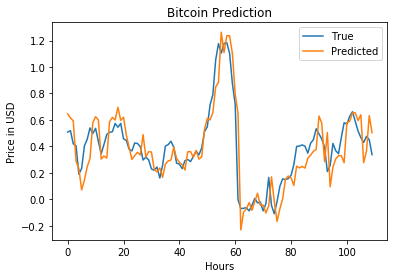

In [59]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train2, y_train2)
y_pred = reg.predict(X_test2)
print('MSE:', mean_squared_error(y_test2, y_pred))
print('MAE:', mean_absolute_error(y_test2, y_pred))

plt.plot(y_test2, label='True')
plt.plot(y_pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [60]:
y_pred_org = (y_pred * std) + mean
y_test_org = (y_test2 * std) + mean

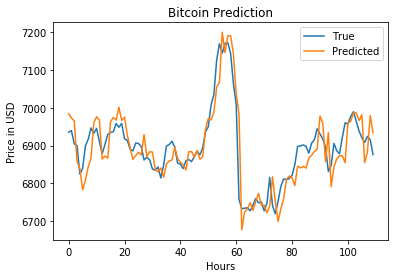

In [61]:
plt.plot(y_test_org, label='True')
plt.plot(y_pred_org, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

In [62]:
print('MSE:', mean_squared_error(y_test_org, y_pred_org))
print('MAE:', mean_absolute_error(y_test_org, y_pred_org))

MSE: 2348.214114775174
MAE: 37.44977745534832


## Applying LSTM

In [63]:
# Applying LSTM
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)
X_train3.shape

(439, 4)

In [64]:
X_train3 = X_train3.reshape(X_train3.shape[0], 4 ,1)

model1 = Sequential()
model1.add(LSTM(128, input_shape=(4,1),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(32, activation='tanh'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer="adam", loss="mean_squared_error")

model1.fit(X_train3, y_train3, epochs=50)

# model1.evaluate(X_test3 , y_test3)

Train on 439 samples
Epoch 1/50
439/439 [==============================] - 4s 9ms/sample - loss: 1.0660
Epoch 2/50
439/439 [==============================] - 0s 206us/sample - loss: 0.5949
Epoch 3/50
439/439 [==============================] - 0s 416us/sample - loss: 0.3230
Epoch 4/50
439/439 [==============================] - 0s 434us/sample - loss: 0.2630
Epoch 5/50
439/439 [==============================] - 0s 303us/sample - loss: 0.2111
Epoch 6/50
439/439 [==============================] - 0s 207us/sample - loss: 0.1700
Epoch 7/50
439/439 [==============================] - 0s 304us/sample - loss: 0.1294
Epoch 8/50
439/439 [==============================] - 0s 191us/sample - loss: 0.0851
Epoch 9/50
439/439 [==============================] - 0s 184us/sample - loss: 0.0758
Epoch 10/50
439/439 [==============================] - 0s 204us/sample - loss: 0.0660
Epoch 11/50
439/439 [==============================] - 0s 243us/sample - loss: 0.0529
Epoch 12/50
439/439 [=======================

MSE: 0.02324098721692105
MAE: 0.11089662187341101


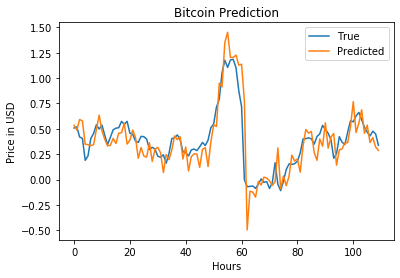

In [65]:
X_test3 = X_test2.reshape(X_test3.shape[0], 4, 1)
y_pred3 = model1.predict(X_test3)
print('MSE:', mean_squared_error(y_test3, y_pred3))
print('MAE:', mean_absolute_error(y_test3, y_pred3))

plt.plot(y_test3, label='True')
plt.plot(y_pred3, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 2835.2783704174344
MAE: 38.733687454541524


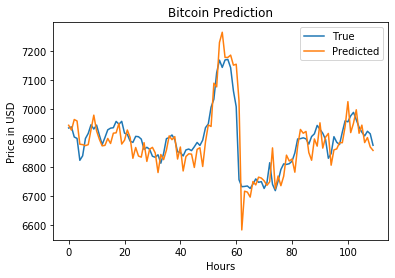

In [66]:
y_pred_org1 = (y_pred3 * std) + mean
y_test_org1 = (y_test3 * std) + mean
print('MSE:', mean_squared_error(y_test_org1, y_pred_org1))
print('MAE:', mean_absolute_error(y_test_org1, y_pred_org1))
plt.plot(y_test_org1, label='True')
plt.plot(y_pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

## As Random Forest Regressor gives the least MAE, we implement this algorithm for the 30 day hourly prediction.

MSE: 0.006886294919313748
MAE: 0.055341928109697645


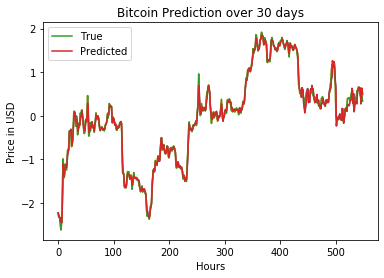

In [67]:
# over the entire 30 days time
pred = reg.predict(X3)
plt.plot(pred)
plt.plot(y3)
print('MSE:', mean_squared_error(y3, pred))
print('MAE:', mean_absolute_error(y3, pred))
plt.plot(y3, label='True')
plt.plot(pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()

MSE: 840.0918301732671
MAE: 19.329688587189036
Wall time: 16 ms


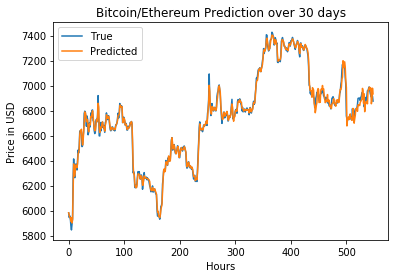

In [68]:
%%time
pred_org1 = (pred * std) + mean
y_org1 = (y3 * std) + mean
print('MSE:', mean_squared_error(y_org1, pred_org1))
print('MAE:', mean_absolute_error(y_org1, pred_org1))
plt.plot(y_org1, label='True')
plt.plot(pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin/Ethereum Prediction over 30 days')
plt.legend()


In [69]:
import pandas as pd
X_new = pd.read_csv("X_new.csv")

In [70]:
X_new

,Sentence,Date,sentiment-sentiment_score,Hour,price1,label1,volume1,Sentiment,score
0,A Quick Garbled Circuits Primer -- vbuterin [v...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9994949}",1.0,5989.014414,5982.209648,1.233530e+07,-1,0.999495
1,"While You’re Under Quarantine, Check These Sit...",2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9978037}",1.0,5982.209648,5945.645879,1.469059e+07,-1,0.997804
2,This is why we Bitcoin!,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.99105054}",13.0,5945.645879,5958.296062,7.071329e+06,-1,0.991051
3,Literally me when dogecoin increases in value,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.97125334}",4.0,5958.296062,5938.628824,8.727236e+06,-1,0.971253
4,Bitcoin May Be One of the Last Assets Still Tr...,2020-03-23,"{'label': 'NEGATIVE', 'score': 0.9984334}",12.0,5938.628824,5878.498745,1.074222e+07,-1,0.998433
...,...,...,...,...,...,...,...,...,...
544,🔥Invading Ethereum USDT,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.8824061}",14.0,6938.118922,6920.762739,9.895946e+06,-1,0.882406
545,What Holds Real Decentralization Back,2020-04-22,"{'label': 'POSITIVE', 'score': 0.89295495}",16.0,6920.762739,6908.007195,1.137203e+07,1,0.892955
546,Russians turn to cash and Bitcoin as coronavir...,2020-04-22,"{'label': 'NEGATIVE', 'score': 0.99790883}",13.0,6908.007195,6924.069889,6.563974e+06,-1,0.997909
547,"Tether Mints $720,000,000 This Month | More Th...",2020-04-22,"{'label': 'POSITIVE', 'score': 0.7023987}",17.0,6924.069889,6915.154614,6.009643e+06,1,0.702399


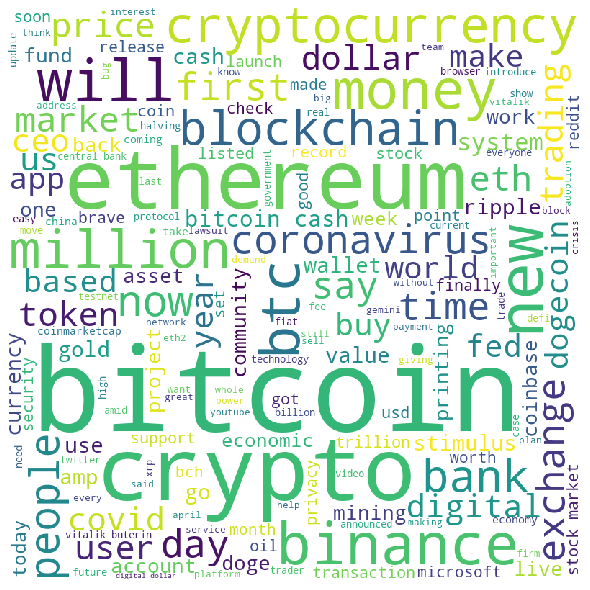

In [71]:
# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
df = X_new["Sentence"]
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("wordcloud.png")
plt.show() 

# 2-hr prediction:

In [72]:
## Btc_data
## same file name different storage loaction for 2-hr prediction
import pandas as pd
data = pd.read_csv('btc_hourly_data.csv')
data

,Time,price,volume,label
0,2020-03-23 03:00:00 UTC,5989.014414,1.233530e+07,5945.645879
1,2020-03-23 04:00:00 UTC,5982.209648,1.469059e+07,5958.296062
2,2020-03-23 05:00:00 UTC,5945.645879,7.071329e+06,5938.628824
3,2020-03-23 06:00:00 UTC,5958.296062,8.727236e+06,5878.498745
4,2020-03-23 07:00:00 UTC,5938.628824,1.074222e+07,5846.105782
...,...,...,...,...
712,2020-04-21 19:00:00 UTC,6920.506165,7.006110e+06,6920.943344
713,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6918.690548
714,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6899.936226
715,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6868.601651


In [73]:
pd.read_csv("final_dataframe_txt_sent_hour").drop(columns = ["Up Votes", "Negative", "Neutral", "Positive", "Compound"])
X = data
X

,Time,price,volume,label
0,2020-03-23 03:00:00 UTC,5989.014414,1.233530e+07,5945.645879
1,2020-03-23 04:00:00 UTC,5982.209648,1.469059e+07,5958.296062
2,2020-03-23 05:00:00 UTC,5945.645879,7.071329e+06,5938.628824
3,2020-03-23 06:00:00 UTC,5958.296062,8.727236e+06,5878.498745
4,2020-03-23 07:00:00 UTC,5938.628824,1.074222e+07,5846.105782
...,...,...,...,...
712,2020-04-21 19:00:00 UTC,6920.506165,7.006110e+06,6920.943344
713,2020-04-21 20:00:00 UTC,6904.699602,6.890824e+06,6918.690548
714,2020-04-21 21:00:00 UTC,6920.943344,6.827119e+06,6899.936226
715,2020-04-21 22:00:00 UTC,6918.690548,7.082099e+06,6868.601651


In [74]:
date12 = []
hour1 = []
price1 = []
label1 = []
volume1 = []
for i in range(len(X)):
    date12.append(X.Time[i][:10])
    hour1.append(X.Time[i][11:13])
    price1.append(X.price[i])
    label1.append(X.label[i])
    volume1.append(X.volume[i])
    
dt = pd.DataFrame(date12, columns = ['Date1'])
hr = pd.DataFrame(hour1, columns = ['hour1'])
pr = pd.DataFrame(price1, columns = ['price1'])
lb = pd.DataFrame(label1, columns = ['label1'])
vol = pd.DataFrame(volume1, columns= ['volume1'])
new_data = pd.concat([dt, hr, pr, lb, vol], axis=1)

In [75]:
# Assining Positive labels : +1
# Assigning Negative Labels : -1

fi = final_dataframe_txt_sent_hour.loc[(final_dataframe_txt_sent_hour['Date'].isin(new_data['Date1']))] 
fi = fi.reset_index().drop(columns = ['index'])
f2 = fi.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral', 'Positive', 'Compound'])
f2.reset_index().drop(columns = ['index']).to_csv("final.csv", index=False)
text_plus_non_text = pd.concat([fi, new_data1], axis=1).dropna()
X = text_plus_non_text.drop(columns = ['Time', 'Up Votes', 'Negative', 'Neutral','Positive', 'Compound', 'Date1', 'hour1'])
X['sentiment-sentiment_score'][0][31:-1]
samples = {}
for i in range(len(X)):  
    temp = X['sentiment-sentiment_score'][i]
    if(temp[11:19] == 'POSITIVE'):
        samples[i] = (1, temp[31:-1])
    else:
        samples[i] = (-1, temp[31:-1])
# print(samples)
data1 = pd.DataFrame.from_dict(samples, orient='index',columns=['Sentiment', 'score'])
X_new = pd.concat([X, data1], axis=1)
# Therefore X1 = data and y1 = label
DATA = X_new.drop(columns = ['sentiment-sentiment_score', 'Sentence'])
y1 = X_new["label1"]

In [76]:
X1 = DATA.drop(columns = ['Date', 'Hour', 'label1'])
X1.head()

,price1,volume1,Sentiment,score
0,5989.014414,1.233530e+07,-1,0.9994949
1,5982.209648,1.469059e+07,-1,0.9978037
2,5945.645879,7.071329e+06,-1,0.99105054
3,5958.296062,8.727236e+06,-1,0.97125334
4,5938.628824,1.074222e+07,-1,0.9984334


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X1.values, y1.values, shuffle=False, test_size=0.2)

## Applying Random Forest Regreesor

In [78]:
reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
# normalizing the data
normalized_data = DATA.drop(columns=['Date', 'Hour', 'Sentiment', 'score']).apply(zscore)
X2 = pd.concat([normalized_data, X1['Sentiment'], X1['score']], axis=1)
y2 = normalized_data['label1']
mean, std = DATA['label1'].mean(), DATA['label1'].std()
# X2 = X2.drop(columns = ['label1'])
X2.head()

MSE: 2628.338648682028
MAE: 37.5399577215708


,price1,label1,volume1,Sentiment,score
0,-2.149213,-2.182381,-0.257897,-1,0.9994949
1,-2.168397,-2.285895,-0.101065,-1,0.9978037
2,-2.271476,-2.250082,-0.608410,-1,0.99105054
3,-2.235813,-2.305761,-0.498148,-1,0.97125334
4,-2.291258,-2.475993,-0.363976,-1,0.9984334


In [79]:
X2.to_csv("reddit_data_normalized.csv", index=False)
Data_new = pd.read_csv("reddit_data_normalized.csv")
Data_new
X3 = Data_new.drop(columns =['label1'])
y3 = Data_new.label1

MSE: 0.02133948245914674
MAE: 0.10687607418036603


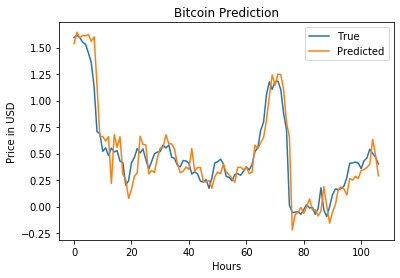

In [80]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)

reg = RandomForestRegressor(n_estimators=250, max_depth=100, random_state=28)
reg.fit(X_train2, y_train2)
y_pred = reg.predict(X_test2)
print('MSE:', mean_squared_error(y_test2, y_pred))
print('MAE:', mean_absolute_error(y_test2, y_pred))

plt.plot(y_test2, label='True')
plt.plot(y_pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 2667.4827560916365
MAE: 37.78673447304262


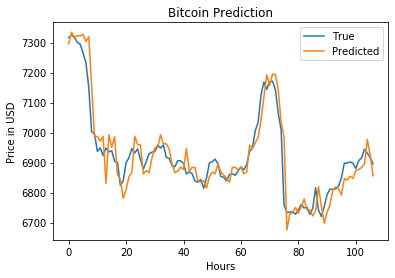

In [81]:
y_pred_org = (y_pred * std) + mean
y_test_org = (y_test2 * std) + mean
plt.plot(y_test_org, label='True')
plt.plot(y_pred_org, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()
print('MSE:', mean_squared_error(y_test_org, y_pred_org))
print('MAE:', mean_absolute_error(y_test_org, y_pred_org))

## Applying LSTM

In [82]:
# Applying LSTM
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3.values, y3.values, shuffle=False, test_size=0.2)


In [83]:
X_train3 = X_train3.reshape(X_train3.shape[0], 4 ,1)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

model1 = Sequential()
model1.add(LSTM(128, input_shape=(4,1),return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(32, activation='tanh'))
model1.add(Dense(1, activation='linear'))

model1.compile(optimizer="adam", loss="mean_squared_error")

model1.fit(X_train3, y_train3, epochs=50)


Train on 425 samples
Epoch 1/50
425/425 [==============================] - 2s 6ms/sample - loss: 0.9276
Epoch 2/50
425/425 [==============================] - 0s 183us/sample - loss: 0.4084
Epoch 3/50
425/425 [==============================] - 0s 188us/sample - loss: 0.2915
Epoch 4/50
425/425 [==============================] - 0s 181us/sample - loss: 0.2299
Epoch 5/50
425/425 [==============================] - 0s 185us/sample - loss: 0.1879
Epoch 6/50
425/425 [==============================] - 0s 181us/sample - loss: 0.1436
Epoch 7/50
425/425 [==============================] - 0s 190us/sample - loss: 0.0997
Epoch 8/50
425/425 [==============================] - 0s 174us/sample - loss: 0.0787
Epoch 9/50
425/425 [==============================] - 0s 169us/sample - loss: 0.0651
Epoch 10/50
425/425 [==============================] - 0s 194us/sample - loss: 0.0608
Epoch 11/50
425/425 [==============================] - 0s 180us/sample - loss: 0.0536
Epoch 12/50
425/425 [=======================

MSE: 0.024273938505249833
MAE: 0.1092061364963209


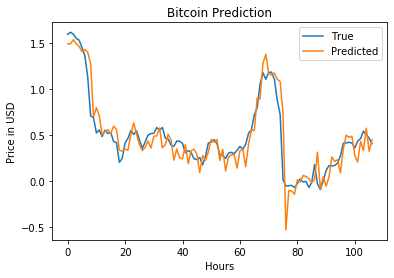

In [84]:
X_test3 = X_test2.reshape(X_test3.shape[0], 4, 1)
y_pred3 = model1.predict(X_test3)
print('MSE:', mean_squared_error(y_test3, y_pred3))
print('MAE:', mean_absolute_error(y_test3, y_pred3))

plt.plot(y_test3, label='True')
plt.plot(y_pred3, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

MSE: 3034.2974937454132
MAE: 38.61057616250882


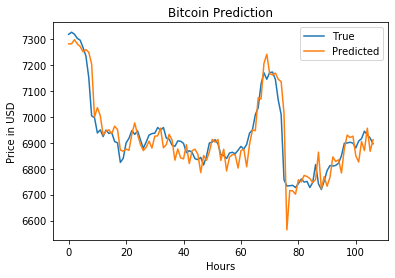

In [85]:
y_pred_org1 = (y_pred3 * std) + mean
y_test_org1 = (y_test3 * std) + mean
print('MSE:', mean_squared_error(y_test_org1, y_pred_org1))
print('MAE:', mean_absolute_error(y_test_org1, y_pred_org1))
plt.plot(y_test_org1, label='True')
plt.plot(y_pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction')
plt.legend()

## As Random Forest Regressor gives the least MAE, we implement this algorithm for the 30 day hourly prediction.

MSE: 0.007144180990144433
MAE: 0.05405804834795455


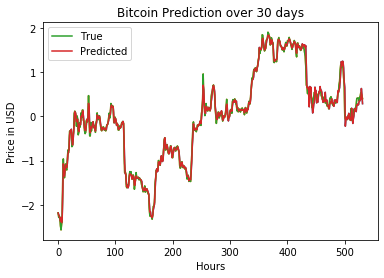

In [86]:
# over the entire 30 days time

pred = reg.predict(X3)
plt.plot(pred)
plt.plot(y3)
print('MSE:', mean_squared_error(y3, pred))
print('MAE:', mean_absolute_error(y3, pred))
plt.plot(y3, label='True')
plt.plot(pred, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin Prediction over 30 days')
plt.legend()

MSE: 893.0385089746898
MAE: 19.112576268546313
Wall time: 14 ms


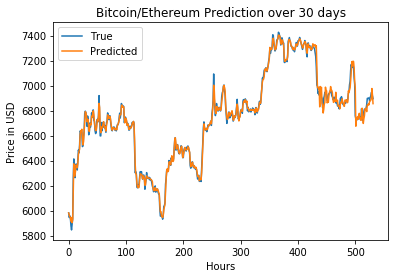

In [87]:
%%time
pred_org1 = (pred * std) + mean
y_org1 = (y3 * std) + mean
print('MSE:', mean_squared_error(y_org1, pred_org1))
print('MAE:', mean_absolute_error(y_org1, pred_org1))
plt.plot(y_org1, label='True')
plt.plot(pred_org1, label='Predicted')
plt.ylabel('Price in USD')
plt.xlabel('Hours')
plt.title('Bitcoin/Ethereum Prediction over 30 days')
plt.legend()


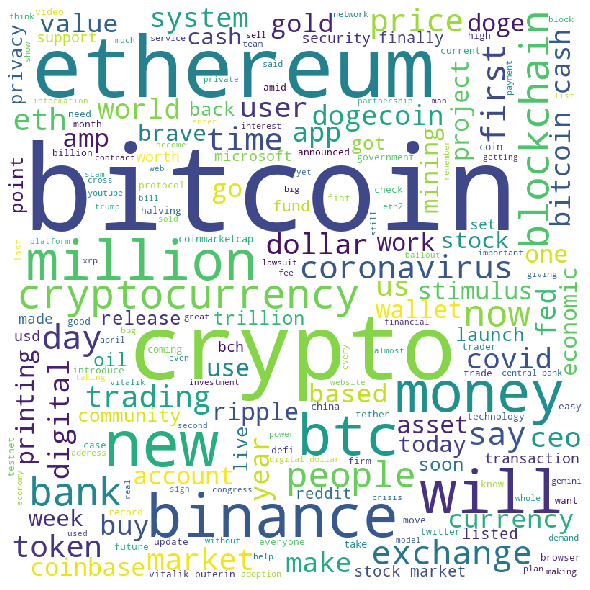

In [88]:
# Python program to generate WordCloud 
  
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
# Reads 'Youtube04-Eminem.csv' file  
df = X_new["Sentence"]
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig("wordcloud.png")
plt.show() 